In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, MDS, trustworthiness
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

filename = 'SDR 2021 - Database.xlsx'

In [2]:
X = pd.read_excel(filename,sheet_name='Raw Data')
X.drop('Population in 2020',axis=1,inplace=True)
X['Regions used for the SDG Index & Dashboard'] = pd.Series(X['Regions used for the SDG Index & Dashboard'],dtype='category')
Y = pd.read_excel(filename,sheet_name='SDR2021 Data', usecols='B,C')
# No he decidido si eliminarlos o si predecir el score con ellos.
Ys = Y.dropna(subset=['2021 SDG Index Score']) # Se eliminan los que no tienen variable de respuesta por resultar inútiles. 
df = X.merge(Y,on='Country',how='inner').set_index('Country')
valid_values = X.merge(Ys,on='Country',how='inner').set_index('Country')
X.set_index('Country',inplace=True)
X = X.loc[:, X.isnull().mean()<0.2]
Y.set_index('Country',inplace=True)
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, United States to Zimbabwe
Columns: 124 entries, Country Code ISO3 to 2021 SDG Index Score
dtypes: category(1), float64(122), object(1)
memory usage: 187.5+ KB


None

,Poverty headcount ratio at $1.90/day (%),Poverty headcount ratio at $3.20/day (%),Poverty rate after taxes and transfers (%),Prevalence of undernourishment (%),Prevalence of stunting in children under 5 years of age (%),Prevalence of wasting in children under 5 years of age (%),"Prevalence of obesity, BMI ≥ 30 (% of adult population)",Human Trophic Level (best 2-3 worst),Cereal yield (tonnes per hectare of harvested land),Sustainable Nitrogen Management Index (best 0-1.41 worst),...,Access to and affordability of justice (worst 0–1 best),"Persons held in prison (per 100,000 population)",Government spending on health and education (% of GDP),For high-income and all OECD DAC countries: International concessional public fi,Other countries: Government revenue excluding grants (% of GDP),Corporate Tax Haven Score (best 0-100 worst),Financial Secrecy Score (best 0-100 worst),Shifted profits of multinationals (US$ billion),Statistical Performance Index (worst 0-100 best),2021 SDG Index Score
count,161.000000,161.000000,36.000000,163.000000,186.000000,186.000000,188.000000,176.000000,176.000000,186.000000,...,126.000000,37.000000,183.000000,39.000000,109.000000,190.000000,37.000000,36.000000,173.000000,165.000000
mean,13.351118,24.223913,11.730556,8.873067,16.720323,4.399462,19.670213,2.279256,3.609472,0.818306,...,0.562579,149.139622,7.962951,0.341795,23.219119,16.039553,54.649378,0.399611,62.991035,66.777508
std,21.161522,29.349636,3.967426,9.873508,13.810275,4.283715,10.943890,0.181145,3.414221,0.243627,...,0.110232,112.382481,3.802588,0.259381,11.885227,28.279526,8.397195,42.367458,17.686703,10.530242
min,0.000000,0.000000,4.900000,1.170000,1.700000,0.000000,2.100000,2.025000,0.123000,0.011000,...,0.351000,39.104000,1.724000,0.080000,0.000000,0.000000,37.550000,-126.229000,19.618000,38.271177
25%,0.240000,0.520000,8.475000,2.500000,2.625000,0.725000,9.575000,2.171750,1.558750,0.639000,...,0.477750,77.442000,5.108000,0.155000,16.070000,0.000000,50.088000,0.837750,51.991000,58.791370
50%,1.390000,9.150000,11.150000,4.700000,11.750000,3.100000,20.600000,2.267000,3.007500,0.829000,...,0.561000,113.408000,7.484000,0.250000,21.506000,0.000000,54.025000,4.089500,61.653000,68.448949
75%,22.040000,40.750000,15.850000,12.150000,27.825000,6.375000,25.600000,2.370500,4.814500,0.996500,...,0.636250,195.122000,9.722000,0.430000,28.004000,40.101000,58.675000,12.228500,78.136000,74.209297
max,84.770000,96.170000,17.900000,48.200000,54.200000,22.700000,61.000000,4.000000,27.838000,1.367000,...,0.817000,671.074000,22.784000,1.030000,99.569000,100.000000,74.050000,123.574000,90.094000,85.901163


In [3]:
colores = ['blue','red','green','yellow','orange','purple','black']
etiquetas = X['Regions used for the SDG Index & Dashboard'].unique()

c_dict = dict(zip(etiquetas,colores))

# Herramientas
imputer = Pipeline(
    [
        ('Scaler',PowerTransformer(method='yeo-johnson',standardize=True)),
        ('KNN Imputer', KNNImputer(n_neighbors=7)),
    ]
)

transformer = ColumnTransformer(
    [
        ('Impute and scale', imputer, make_column_selector(dtype_include=np.number)),
        ('Encoder Region',OneHotEncoder(),['Regions used for the SDG Index & Dashboard'])
    ]
)

LLE = LocallyLinearEmbedding(n_neighbors=7,n_components=2,reg=1e-3,method='standard')
tsne = TSNE(perplexity=5,learning_rate='auto',random_state=420)
isomap = Isomap(n_neighbors=7,n_components=2)
mds = MDS(n_init=10)
iso3d = Isomap(n_neighbors=7,n_components=3,metric='cosine')

manifold3diso = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',iso3d)
    ]
)

new_manifold = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',LLE)
    ]
)
tsne_manifold = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',tsne)
    ]
)


isomap_manifold = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',isomap)
    ]
)

mds_manifold = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',mds)
    ]
)


df.dtypes()

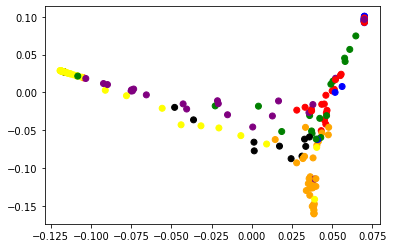

In [4]:
new_manifold.fit(X.select_dtypes(np.number))
x1, x2 = new_manifold.transform(X.select_dtypes(np.number)).T
plt.scatter(x1,x2,c=X['Regions used for the SDG Index & Dashboard'].map(c_dict))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


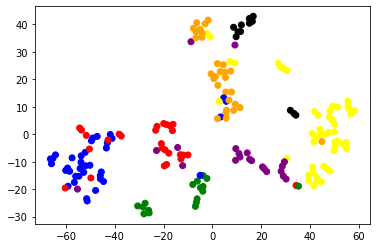

In [5]:
tsne_manifold.fit(X.select_dtypes(np.number))
x1, x2 = tsne_manifold.fit_transform(X.select_dtypes(np.number)).T

plt.scatter(x1,x2, c=X['Regions used for the SDG Index & Dashboard'].map(c_dict),label=X['Regions used for the SDG Index & Dashboard'])

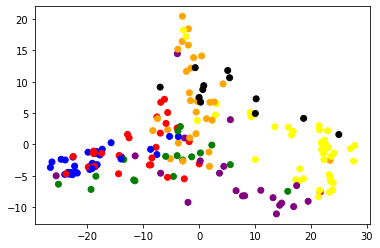

In [6]:
x1, x2 = isomap_manifold.fit_transform(X.select_dtypes(np.number)).T
plt.scatter(x1,x2, c=X['Regions used for the SDG Index & Dashboard'].map(c_dict))


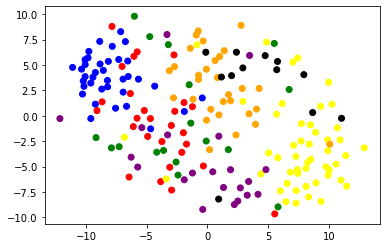

In [7]:
x1, x2 = mds_manifold.fit_transform(X.select_dtypes(np.number)).T
plt.scatter(x1,x2, c=X['Regions used for the SDG Index & Dashboard'].map(c_dict))


In [8]:
simple_df = pd.read_excel(filename,sheet_name='SDR2021 Data', usecols='B,WR:XH')
simple_df_labels = pd.read_excel(filename,sheet_name='SDR2021 Data', usecols='B,H')
simple_df.set_index('Country',inplace=True)
simple_df_labels.set_index('Country',inplace=True)
simple_df.dropna(how='all',inplace=True)

removals = ['Eastern Europe and Central Asia',
'East and South Asia',
'Latin America and the Caribbean',
'Middle East and North Africa',
'Oceania',
'OECD members',
'Small Island Developing States',
'Sub-Saharan Africa',
'Low-income Countries',
'Lower-middle-income Countries',
'Upper-middle-income Countries',
'High-income Countries']
simple_df.drop(removals,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


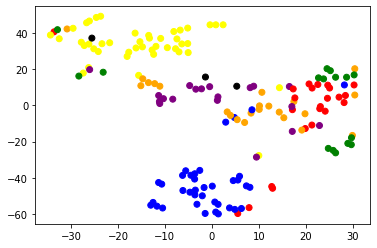

In [9]:
x1,x2 = tsne_manifold.fit_transform(simple_df.select_dtypes(np.number)).T
plt.scatter(x1,x2,c=simple_df.join(simple_df_labels,how='inner')['Regions used for the SDR'].map(c_dict))

In [38]:
import plotly.express as px 

lle3d = LocallyLinearEmbedding(n_neighbors=10,n_components=3,reg=1e-3,method='standard')

manifold3dlle = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',lle3d)
    ]
)
man3d_dflle = pd.DataFrame(data=manifold3dlle.fit_transform(X.select_dtypes(np.number)))
px.scatter_3d(man3d_dflle,x=0,y=1,z=2,color=X['Regions used for the SDG Index & Dashboard'],width=1080,height=720)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



<AxesSubplot:xlabel='1D representation', ylabel='Density'>

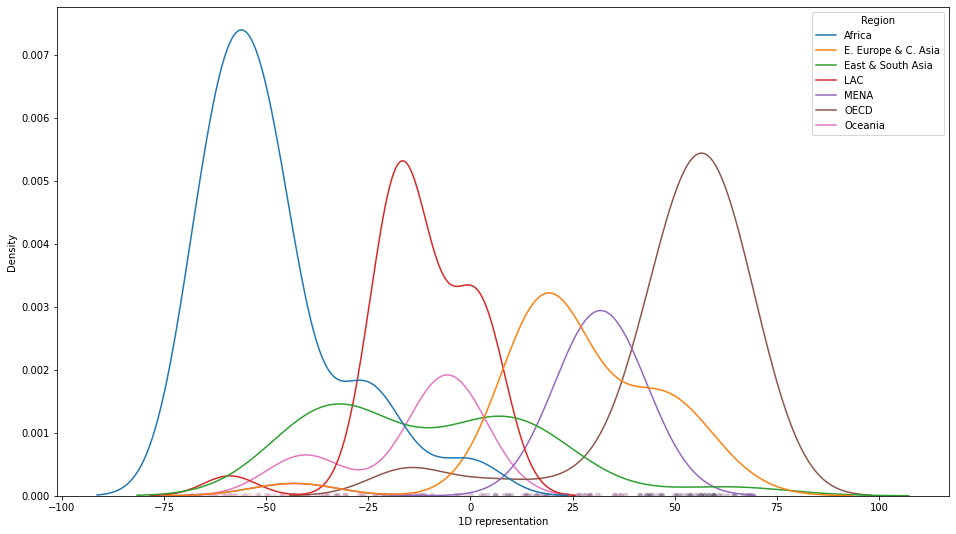

In [12]:
manifold_1d = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',TSNE(n_components=1,perplexity=5,learning_rate='auto',random_state=420))
    ]
)

x1 = (manifold_1d.fit_transform(X.select_dtypes(np.number))).flatten()
plt.figure(figsize=(16,9))
x1 = pd.DataFrame(data={
    "1D representation":x1,
    "Region": X['Regions used for the SDG Index & Dashboard'],
    "SDG Score": Y.join(X,how='right')['2021 SDG Index Score']
    },
    index=X.index
)
sns.scatterplot(x=x1['1D representation'],y=np.zeros_like(x1['1D representation']),alpha=0.3,hue=x1["SDG Score"])
sns.kdeplot(data=x1,x="1D representation",hue='Region')



In [13]:
X

,Country Code ISO3,Regions used for the SDG Index & Dashboard,Poverty headcount ratio at $1.90/day (%),Poverty headcount ratio at $3.20/day (%),Prevalence of undernourishment (%),Prevalence of stunting in children under 5 years of age (%),Prevalence of wasting in children under 5 years of age (%),"Prevalence of obesity, BMI ≥ 30 (% of adult population)",Human Trophic Level (best 2-3 worst),Cereal yield (tonnes per hectare of harvested land),...,Terrestrial and freshwater biodiversity threats embodied in imports (per million,"Homicides (per 100,000 population)",Unsentenced detainees (% of prison population),Birth registrations with civil authority (% of children under age 5),Corruption Perception Index (worst 0-100 best),"Exports of major conventional weapons (TIV constant million USD per 100,000 popu",Press Freedom Index (best 0-100 worst),Government spending on health and education (% of GDP),Corporate Tax Haven Score (best 0-100 worst),Statistical Performance Index (worst 0-100 best)
Country,,,,,,,,,,,,,,,,,,,,,
United States,USA,OECD,0.38,0.52,2.5,3.50,0.4,36.2,2.454,8.692,...,3.741,4.957,23.400,100.0,67.0,3.223,23.85,13.474,43.212,88.924
France,FRA,OECD,0.13,0.17,2.5,2.58,0.7,21.6,2.477,6.885,...,7.095,1.199,28.600,100.0,69.0,3.545,22.92,13.712,55.702,86.348
Germany,DEU,OECD,0.24,0.31,2.5,1.70,0.3,22.3,2.437,6.220,...,5.746,0.948,23.567,100.0,80.0,2.040,12.16,13.784,52.338,87.498
Belgium,BEL,OECD,0.25,0.31,2.5,2.58,0.7,22.1,2.380,8.154,...,4.722,1.690,35.600,100.0,76.0,0.154,12.57,14.232,67.841,82.415
Denmark,DNK,OECD,0.17,0.21,2.5,2.58,0.7,19.7,2.494,4.946,...,1.685,1.008,32.800,100.0,88.0,0.357,8.13,16.263,51.704,86.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Venezuela, RB",VEN,LAC,53.37,77.21,31.4,13.40,4.1,25.6,2.313,3.395,...,0.777,36.688,63.000,81.3,15.0,0.000,45.66,8.579,0.000,43.865
Vietnam,VNM,East & South Asia,0.85,4.40,6.4,23.80,5.8,2.1,2.218,5.685,...,0.138,1.528,12.500,96.1,36.0,0.000,74.71,6.864,0.000,65.959
"Yemen, Rep.",YEM,MENA,NaN,NaN,NaN,46.40,16.4,17.1,2.127,0.759,...,0.039,6.772,70.900,30.7,15.0,0.000,58.25,5.649,0.000,36.771


In [39]:
mds3d = MDS(n_components=3,n_init=10,verbose=True)

manifold3d = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',mds3d)
    ]
)
man3d_df = pd.DataFrame(data=manifold3d.fit_transform(X.select_dtypes(np.number)))
man3d_df['Region'] = X['Regions used for the SDG Index & Dashboard'].to_numpy()
#px.scatter_3d(man3d_df,x=0,y=1,z=2,color='Region')
print(man3d_df)
px.scatter_3d(
    man3d_df,
    x = 0,
    y = 1,
    z = 2,
    color = Y.join(X,how='right')['2021 SDG Index Score'],
    symbol = 'Region',
    width = 1080,
    height = 720,
    opacity = 0.5,
    labels = {
        "0": "Eje 1",
        "1": "Eje 2",
        "2": "Eje 3",
        "Region": "Región",
    },
)

            0         1         2             Region
0    3.300316  8.625605  2.633865               OECD
1    2.408593  8.603148  4.299628               OECD
2    1.379231  8.592360  5.898467               OECD
3    2.476616  7.160252  6.474914               OECD
4    2.130149  8.654132  6.434421               OECD
..        ...       ...       ...                ...
188  4.517978 -0.011963 -4.239237                LAC
189 -4.365752  3.394536 -2.880562  East & South Asia
190 -4.165032 -9.080857 -2.822514               MENA
191  0.121050 -4.069059 -6.749323             Africa
192  0.901292 -1.954213 -8.500001             Africa

[193 rows x 4 columns]


In [22]:

maniso3d_df = pd.DataFrame(data=manifold3d.fit_transform(X.select_dtypes(np.number)))
maniso3d_df['Region'] = X['Regions used for the SDG Index & Dashboard'].to_numpy()
#px.scatter_3d(man3d_df,x=0,y=1,z=2,color='Region')
print(maniso3d_df)
px.scatter_3d(
    maniso3d_df,
    x = 0,
    y = 1,
    z = 2,
    color = Y.join(X,how='right')['2021 SDG Index Score'],
    symbol = 'Region',
    width = 1080,
    height = 720,
    opacity = 0.5,
    labels = {
        "0": "Eje 1",
        "1": "Eje 2",
        "2": "Eje 3",
        "Region": "Región",
    },
)

            0         1         2             Region
0    7.367746  5.434260  3.023305               OECD
1    6.168278  5.601301  5.384811               OECD
2    5.941701  6.312828  5.962326               OECD
3    6.372153  4.297886  6.264382               OECD
4    7.430351  5.904789  5.451900               OECD
..        ...       ...       ...                ...
188  3.850420 -1.306571 -4.675071                LAC
189 -2.191701  5.063051 -2.793098  East & South Asia
190 -8.644680 -5.164658 -2.627704               MENA
191 -1.848501 -3.729366 -6.709095             Africa
192 -0.107881 -2.843413 -8.267011             Africa

[193 rows x 4 columns]


No olvides jugar con la gráfica! :D 


In [55]:
def make_trustworthiness_table(X, models: dict):
    vals = {}
    for key in models:
        datum = models[key].fit_transform(X)
        premap = models[key]['Imputer'].transform(X)
        trust = trustworthiness(premap,datum)
        vals[key] = trust
    return vals

models = {
    "LLE 2D": new_manifold,
    "LLE 3D": manifold3dlle,
    "ISO 2D": isomap_manifold,
    "ISO 3D": manifold3diso,
    "MDS 2D": mds_manifold,
    "TSNE 1D": manifold_1d,
    "TSNE 2D": tsne_manifold,
}
make_trustworthiness_table(X.select_dtypes(np.number),models)
#trustworthiness(manifold3d['Imputer'].transform(X.select_dtypes(np.number)),man3d_df.drop('Region',axis=1))
#trustworthiness(manifold3d['Imputer'].transform(X.select_dtypes(np.number)),man3d_df)
#trustworthiness(manifold3d['Imputer'].transform(X.select_dtypes(np.number)),man3d_df)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



{'LLE 2D': 0.8884301918498809,
 'LLE 3D': 0.901845679876768,
 'ISO 2D': 0.895235961349951,
 'ISO 3D': 0.9262456238622042,
 'MDS 2D': 0.9100518134715025,
 'TSNE 1D': 0.9516146198011483,
 'TSNE 2D': 0.9670018204733231}

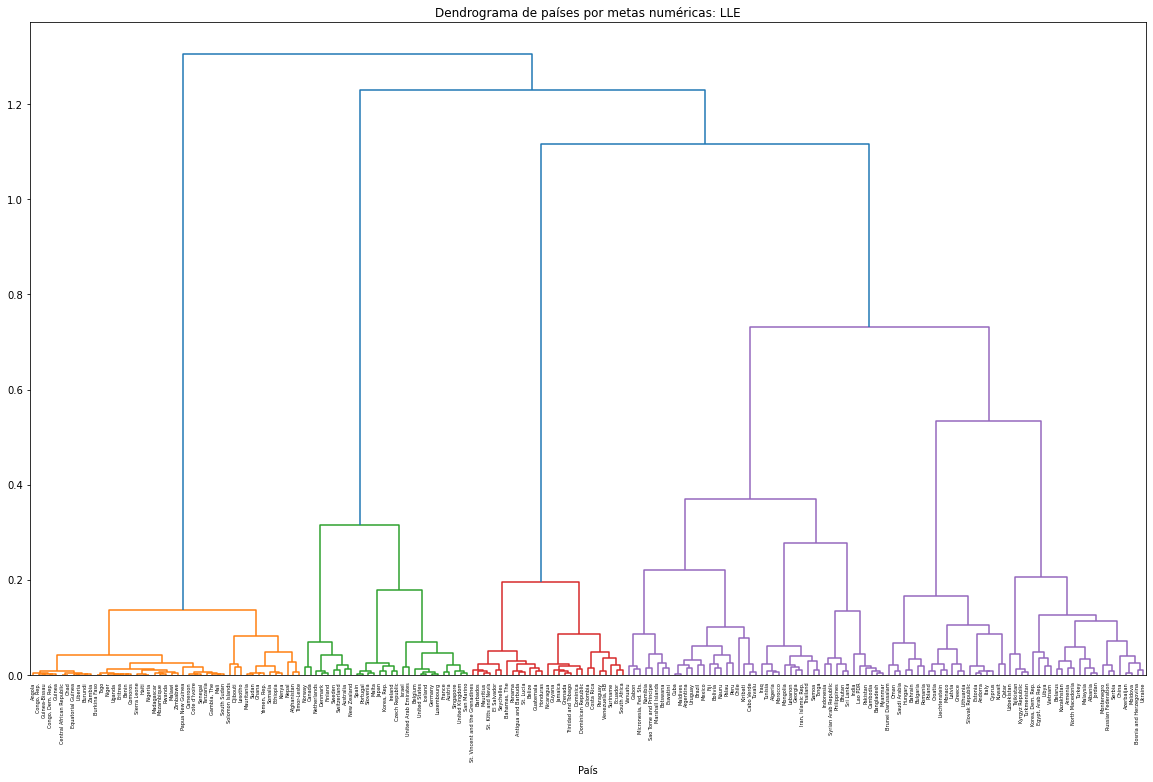

In [56]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model['Clustering'].children_.shape[0])
    n_samples = len(model['Clustering'].labels_)
    for i, merge in enumerate(model['Clustering'].children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model['Clustering'].children_, model['Clustering'].distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',lle3d),
        ('Clustering',AgglomerativeClustering(distance_threshold=0, n_clusters=None))
    ]
)

model = model.fit(X.select_dtypes(np.number))

plt.figure(figsize=(20,12))
plt.title("Dendrograma de países por metas numéricas: LLE")
plot_dendrogram(model,labels=X.index)
plt.xlabel("País")
plt.savefig("DendrogramaLLE.svg",dpi=500,format='svg')
plt.show() 

In [ ]:
def make_small_summary(dframe):
    return pd.DataFrame(
        data = {
            "Mean": dframe.mean(numeric_only=True),
            "Median": dframe.median(numeric_only=True),
            "Count": dframe.count(numeric_only=True),
            "Variance": dframe.var(numeric_only=True),
            "Skewness": dframe.skew(numeric_only=True),
            "Excess kurtosis": dframe.kurtosis(numeric_only=True)
        },
        index=dframe.columns
    )
def plot_skew_kurt(dframe,**kwargs):
    plt.figure()
    sns.kdeplot(data=dframe,x='Skewness',**kwargs)
    sns.histplot(data=dframe,x='Skewness',stat='density',**kwargs)
    plt.title("Coeficientes de asimetría de los datos numéricos")
    plt.ylabel("Densidad")
    plt.xlabel("Asimetría")
    plt.show()
    plt.figure()
    sns.kdeplot(data=dframe,x='Excess kurtosis',**kwargs)
    sns.histplot(data=dframe,x='Excess kurtosis',stat='density',**kwargs)
    plt.title("Curtosis en exceso de los datos numéricos")
    plt.ylabel("Densidad")
    plt.xlabel("Curtosis")

resumen=make_small_summary(X)

plot_skew_kurt(resumen)



Xnum = X.select_dtypes(np.number)
datumm = pd.DataFrame(data=imputer.fit_transform(X.select_dtypes(np.number)))

plot_skew_kurt(make_small_summary(datumm),color='purple')

plt.figure(figsize=(16,9))
sns.ecdfplot(data=(Xnum-Xnum.min())/(Xnum.max()-Xnum.min()),legend=False)
plt.xlabel('Min-max normalized values')
plt.xlim([0,1])
plt.grid()
plt.figure(figsize=(16,9))
sns.ecdfplot(data=datumm,legend=False)
plt.grid()

In [18]:
man3d_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       193 non-null    float64
 1   1       193 non-null    float64
 2   2       193 non-null    float64
 3   Region  193 non-null    object 
dtypes: float64(3), object(1)
memory usage: 6.2+ KB


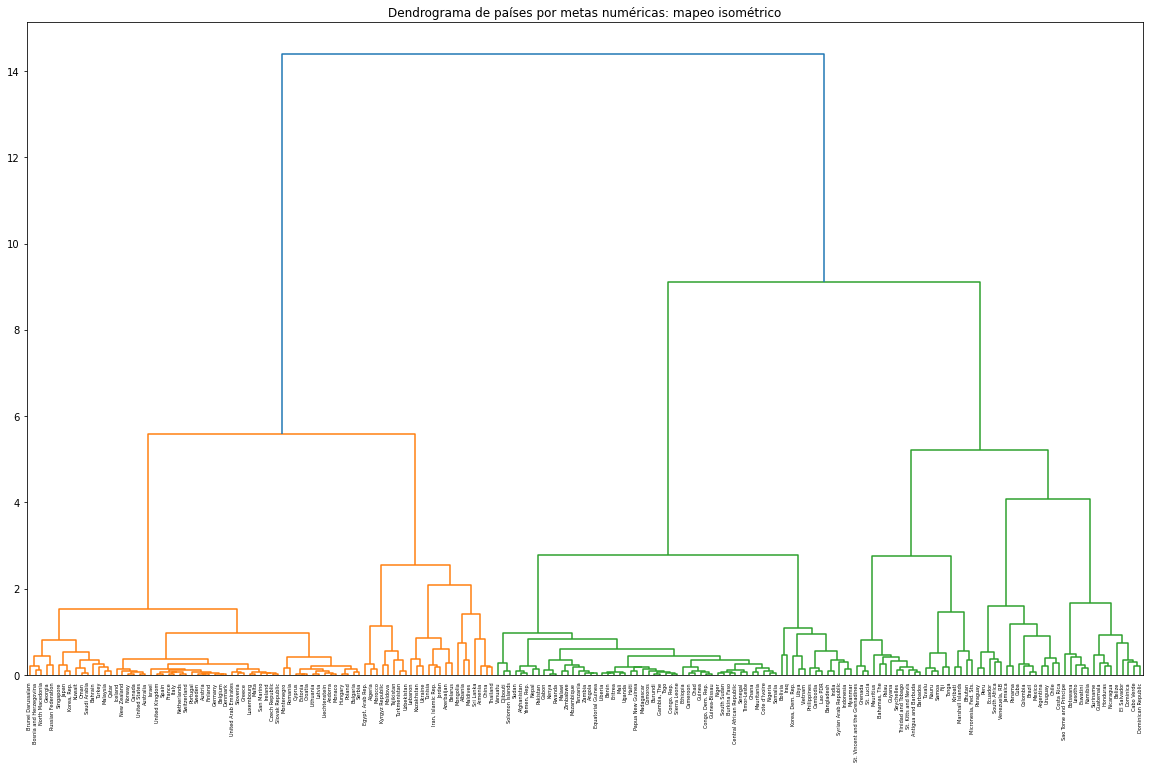

In [57]:
clusteriso3d = Pipeline(
    [
        ('Imputer',imputer),
        ('Manifold',iso3d),
        ('Clustering',AgglomerativeClustering(n_clusters=None,distance_threshold=0))
    ]
)

plt.figure(figsize=(20,12))
plt.title("Dendrograma de países por metas numéricas: mapeo isométrico")
plot_dendrogram(clusteriso3d.fit(X.select_dtypes(np.number)),labels=X.index)
plt.savefig("Dendrograma_isomap.svg",format='svg',dpi=500)

In [50]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=10)

pcared = Pipeline(
    [
        ("Impute and scale",imputer),
        ("Manifold",pca)
    ]
)
pcared.fit(X.select_dtypes(np.number))
np.cumsum(pcared['Manifold'].explained_variance_ratio_)

array([0.51608535, 0.57354033, 0.62476547, 0.65726277, 0.68587592,
       0.7099547 , 0.73174256, 0.74951064, 0.76598185, 0.78025366])

No se usa PCA debido a que muestra muy poco de la información incluso a dimensiones mayores a 10, por lo que para los propósitos de estos mapeos no resulta tan útil.

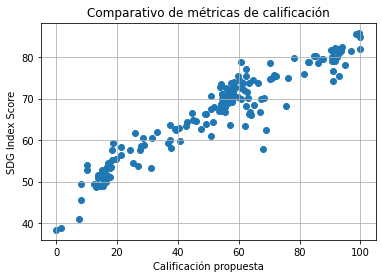

In [91]:
# Calificación

lle1d = LocallyLinearEmbedding(n_components=1,n_neighbors=7,method='modified')

lle1d_manifold = Pipeline(
    [
        ("Impute and scale", imputer),
        ("Manifold", lle1d)
    ]
)
lle1d_manifold.fit(simple_df)
datos = lle1d_manifold.transform(simple_df)
datos = (datos-min(datos))/(max(datos)-min(datos))*100 # Normalizados para que sea una escala normal
plt.scatter(datos,Y.join(simple_df,how='right',on='Country')['2021 SDG Index Score'])
plt.xlabel("Calificación propuesta")
plt.ylabel("SDG Index Score")
plt.grid()
plt.title("Comparativo de métricas de calificación")
plt.savefig("comparativo.svg",format="svg")